<h1 align='center'>Cyberbullying Detection</h1>
<img src="cyber-bullying.jpeg" alt="Alternative text" width=500 height=200/>

# Abstract
With rise of social media coupled with the Covid-19 pandemic, cyberbullying has reached all time highs. We can combat this by creating models to automatically flag potentially harmful tweets as well as break down the patterns of hatred.

# About this dataset
This dataset contains more than 47000 tweets labelled according to the class of cyberbullying:

Age<br>
Ethnicity<br>
Gender<br>
Religion<br>
Other type of cyberbullying<br>
Not cyberbullying<br>
The data has been balanced in order to contain ~8000 of each class.

# Bussiness Constraints 
No low-latency contraints<br>
Interpretability is partially important<br>
Probability of class predicted is important so we can tune prob_score if required in production.

#  Mapping the real-world problem to an ML problem¶
### 1) Type of Machine Learning Problem:
    Since there is 6 different classes a query can belong it is a multiclass classification problem.
### 2) Performance Metric
    Multiclass-LogLoss
    Confusion Matrix 

# How to use this dataset
Create a multiclassification model to predict cyberbullying type<br>
Create a binary classification model to flag potentially harmful tweets<br>
Explore words and patterns associated with each type of cyberbullying.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import time
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

from wordcloud import WordCloud, STOPWORDS

from os import path
from PIL import Image
import warnings
warnings.filterwarnings("ignore")

In [2]:
# reading the data
df = pd.read_csv("cyberbullying_tweets.csv")
print("Number of rows in the data: ", df.shape[0])
print("Number of columns in the data: ", df.shape[1])

Number of rows in the data:  47692
Number of columns in the data:  2


In [3]:
df.head()

tweet_text cyberbullying_type
0  In other words #katandandre, your food was cra...  not_cyberbullying
1  Why is #aussietv so white? #MKR #theblock #ImA...  not_cyberbullying
2  @XochitlSuckkks a classy whore? Or more red ve...  not_cyberbullying
3  @Jason_Gio meh. :P  thanks for the heads up, b...  not_cyberbullying
4  @RudhoeEnglish This is an ISIS account pretend...  not_cyberbullying

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47692 entries, 0 to 47691
Data columns (total 2 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   tweet_text          47692 non-null  object
 1   cyberbullying_type  47692 non-null  object
dtypes: object(2)
memory usage: 745.3+ KB


In [5]:
print("Number of duplicated rows in the dataset :",df.duplicated().sum())
df[df.duplicated()]

Number of duplicated rows in the dataset : 36


tweet_text cyberbullying_type
1758   Our pancakes are selling like hotcakes Shaz - ...  not_cyberbullying
3833   But you all respect him....Pete hasn't read tw...  not_cyberbullying
3939   This is the opportunity to prove ourselves lik...  not_cyberbullying
5684   Strategicscoring should be classed as cheating...  not_cyberbullying
6975   If we're at the bottom of the leaderboard, we'...  not_cyberbullying
7227   It wouldn't be fair. Kat knows NOTHING of fair...  not_cyberbullying
7278   @TVWEEKmag: There is only 1 way to stay in the...  not_cyberbullying
7822   @Ima_TV_Junkie: What the hell were Annie and L...  not_cyberbullying
9672   @victorymonk: #sorryitsaboy joke means more bo...             gender
9835   @thisonesakillaa: In my opinion? All jokes are...             gender
11076  Simple things please simple minds. @pumpkinkin...             gender
12664  No offense. @NigelBigMeech I'm not sexist but ...             gender
12695  raped is not a synonym for "touched" @magconbo...             gender
12714  @Transic_nyc: What do u think her punishment s...             gender
12789  girls @Dehner07 In usually not sexist, but gir...             gender
12851  We've proven we're not just dumb blondes and p...             gender
13396  We proved that we're not just pretty faces. Oh...             gender
13830  @ErikssonMalin85: #QuestionsForMen ever walked...             gender
13839  We want everyone to know we are not just prett...             gender
13859  girl sports gives it away here @LM26_LYE_ERA I...             gender
14102  Females and "guys." @AwkwardEP I'm not sexist ...             gender
14222  @nethercott_eden: Why is #WomenAgainstFeminism...             gender
14235  I'm not sexist, except when I am. @gentlemanby...             gender
14286  I'm not sexist, there are women everywhere! @d...             gender
14516  Women's bathrooms are so much worse than men's...             gender
14760  @ErikssonMalin85: Have u ever expressed ur ang...             gender
15018  Radical? lol no @David_i_think Call me sexist....             gender
15420  @MHWitchfinder: Please, if you disagree with H...             gender
15422  I'm not sexist, I just become instantly virule...             gender
15572  @botticellicream: I'm curvy. The kind men fap ...             gender
15839  We're not just the dumb blondes with the prett...             gender
15849  just don't = the sum total of your unconscious...             gender
15887  @fee_bee_63: Kat is a completely rank cow but ...             gender
20604  A Pakistani court has sentenced 86 members of ...           religion
46962  Still, Davis, who is gay, said he pays a socia...          ethnicity
47397  Racism won't stop as long as u stil select ur ...          ethnicity

In [6]:
df.drop_duplicates(inplace=True)
print("Number of duplicated rows in the dataset :",df.duplicated().sum())

Number of duplicated rows in the dataset : 0


<AxesSubplot:>

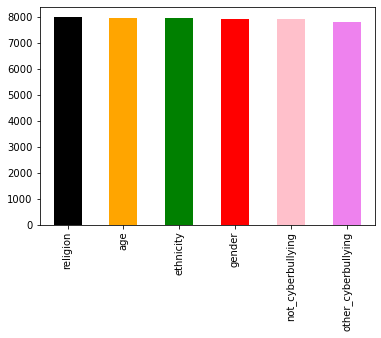

In [7]:
c = ['black','orange','green','red','pink','violet','yellow']
df['cyberbullying_type'].value_counts().plot.bar(color=c)

### so we can see that the class labels are well balanced 

In [8]:
# code to remove emojis from text 
# code by Denis da Mata -- https://stackoverflow.com/questions/33404752/removing-emojis-from-a-string-in-python
text = '✌️sure.. thanks 🙂'
print(text) # with emoji
emoj = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U00002500-\U00002BEF"  # chinese char
        u"\U00002702-\U000027B0"
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U0001f926-\U0001f937"
        u"\U00010000-\U0010ffff"
        u"\u2640-\u2642" 
        u"\u2600-\u2B55"
        u"\u200d"
        u"\u23cf"
        u"\u23e9"
        u"\u231a"
        u"\ufe0f"  # dingbats
        u"\u3030""]+", re.UNICODE)
print(emoj.sub(r'', text)) # no emoji

✌️sure.. thanks 🙂
sure.. thanks 


In [9]:
#code for removing weburls from text -- self coded
#text = "Education Nation: http://localhost:8888/notebooks/AppliedML/cyberbulling/Untitled.ipynb Bullying Turn to 10 http://t.co/sxTIWtp"
#if "http" in text:
#        runs = len(re.findall('http', text))
#        for i in range(runs):
#            sindex = text.find("http")
#            eindex = text.find(" ", sindex)
#            text = re.sub((text[ sindex : eindex ]),"",text)  
#print(text)

## removing emojis
## removing web urls
## Removing username that start with @ symbol
## removing the words other than english
## punctuations and shortcut words removal
## lower case conversions 
## remove if len of word is less than 2
## stop_word removal
## stemming

# loading stop words from nltk library
stop_words = set(stopwords.words('english'))

def text_preprocess(row):
    string=''
    text_raw = row['tweet_text']

    # removing emojis
    text_emoj = emoj.sub(r'', text_raw)
    
    #removing parantheses from tweet_text
    text_emoj = text_emoj.replace("]","").replace("[","").replace("(","").replace(")","").replace("{","").replace("}","")
    
    # removing web urls
    if "http" in text_emoj:
        runs = len(re.findall("http", text_emoj))
        for i in range(runs):
            sindex = text_emoj.find("http")
            eindex = text_emoj.find(" ", sindex)
            text_emoj = re.sub((text_emoj[ sindex : eindex ]),"",text_emoj)  
            
    # Removing username that start with @ symbol
    runs = len(re.findall("@", text_emoj))
    for i in range(runs):
        sindex = text_emoj.find("@")
        eindex = text_emoj.find(" ", sindex)
        text_emoj = re.sub((text_emoj[ sindex : eindex ]),"",text_emoj)
    
    # punctuations and special characters removal 
    text_emoj = text_emoj.replace("'","").replace("\"","").replace("!","").replace("#","").replace("?","").replace("$","dollar ")\
    .replace(":","").replace(";","").replace("*","").replace("^","").replace("%","").replace("~","").replace("`","")\
    .replace("&","").replace("<","").replace(">","").replace(",","").replace("+","").replace("|","").replace("-","")\
    .replace("/","").replace(".","").replace("=","").replace("_","").replace("'m'"," am ").replace("'s'"," is ")\
    .replace("'re'"," are ").replace("'ll'"," will ").replace("'d'"," would ").replace("'m'"," am ").replace("n't"," not ")\
    .replace("'ve"," have ")
    
    # removing the words other than english and convert to lowerclass
    ps = PorterStemmer()
    text_clean = ''
    for x in text_emoj.split(" "):
         # stop_word removal
        if x not in stop_words:
            if re.search(r"([a-zA-Z]+)",x):
                if len(x)>2:
                    # stemming using NLTK library
                    x = ps.stem(x.lower())
                    text_clean = text_clean + " " + x
    
    # return NAN if len of each text is less than 2
    if len(text_clean) < 3:
        return float('nan')
    else:
        return text_clean

In [10]:
df['text_preprocessed'] = df.apply(text_preprocess,axis=1)

In [11]:
def print_text(row):
    print(row['tweet_text'])
df.apply(print_text,axis=1)

In other words #katandandre, your food was crapilicious! #mkr
Why is #aussietv so white? #MKR #theblock #ImACelebrityAU #today #sunrise #studio10 #Neighbours #WonderlandTen #etc
@XochitlSuckkks a classy whore? Or more red velvet cupcakes?
@Jason_Gio meh. :P  thanks for the heads up, but not too concerned about another angry dude on twitter.
@RudhoeEnglish This is an ISIS account pretending to be a Kurdish account.  Like Islam, it is all lies.
@Raja5aab @Quickieleaks Yes, the test of god is that good or bad or indifferent or weird or whatever, it all proves gods existence.
Itu sekolah ya bukan tempat bully! Ga jauh kaya neraka
Karma. I hope it bites Kat on the butt. She is just nasty. #mkr
@stockputout everything but mostly my priest
Rebecca Black Drops Out of School Due to Bullying:
@Jord_Is_Dead http://t.co/UsQInYW5Gn
The Bully flushes on KD http://twitvid.com/A2TNP
Ughhhh #MKR
RT @Kurdsnews: Turkish state has killed 241 children in last 11 years http://t.co/JlvkE1epws  #news  ##Googl

@truaemusic Why would I care what you think of Cameron?
We should take the "Stop The Bullying" & change it to "Quit Being A Dick." #fb
LOL acabei de zerar o Bully q emoçao (_Ô_)
wadhwa is now blaming npr for bad health.
RT @notallmikaylas: My feminist praxis makes relationships &amp; friendships &amp; history classes hard as hell,but I dont want to be comfortable i…
No se si se llama bullying o maltrato infantil lo que @BikinaCOOLebro me esta haciendo en estos momentos #JELP!!!!
@eidlonimp oh. i've got him blocked. i didn't even see that.
RT @AgQueue: #PAXEast Get ggautoblocker and autoblock 12k Twitter trolls: http://t.co/AUrgHkSOX3
@Digitalistic my nickname is grandma. &gt;.&gt;
@a_mezzosangue lol , right (:
RT @Duhokpost: ISIS burnt down the most ancient Church in Mosul. http://t.co/9icXd4F2Fu
@lucaswj it can! but my partner is used to playing rogue, so both of these classes are sorta meh for him.
Well that's MKR done for the year. Seriously, does anyone watch past the instant resta

I'm not a fan of the blonde butchers, but those scores seemed awfully low #mkr
@SnowdenNHL @nhlexpertpicks he will never win a Cup for this stunt. #carma
No school, served people food at the outreach dinner, saw one of my tshirt designs on 100s of people, and ended with playin ball! #GoodDay
Looking forward to leaving for lunch #getmeoutofhere
I care so much that I couldn't care less. Today marks the start of my very #best
rage eating pocky
@aluizanogueira voce ta ai com as meninas e eu FOREVER ALONE aqui por causa da professora que tem bullying comigo :/
As Real As It Gets: Bullying Victims Can Fight Back With Help From Brazilian Jiu-Jitsu Royalty http://t.co/sl71Cnx
@Kevin_elitelive lool allow me! It was bigggg
RT @GidgitVonLaRue: #MKR Of course you are sold out Mt Isa girls - you put twenty pancakes on each plate!
@Lithobolos @PoliticalAnt @ZaibatsuNews You seem to be rambling without a point.
Bitches practically bullied me into going out tonight, good thing I get paid at midnight :

Everybody made a rape/gay/molesting joke about Michael Jackson idc what y'all say
Kat seriously turn it down... #mkr
#KellyFile #Hannity #TCOT
RT @Mickens__: This is the exact reason why Women shouldn't be involved. Not sexist. But situations like this will always be blown out of p…
RT @Wateronatrain: @MT8_9 You might like this http://t.co/c9m2pFmFJ3 #patriarchy
Oh kat.... never mind #cuntandandre #mkr
@ThatSabineGirl Green and Purple wasn't a rape joke. It was two MEN appreciating each other's bodies. It's about spreading gay awareness.
Why do straight AND gay men think rape jokes are funny?
I'm so disgusted that people like Kat is allowed in this competition #mkr
RT @jamiecowan92: @frankthewank1 they don't even know what they want, then they say things like "it's a woman's prerogative to change her m…
How come straight women think rape jokes about gay men are funny?
RT @MarkTrueblood: TRUTH! A smart woman explains why men don't want to have to "handle" their wives and girlfriends. ht

@Sargon_of_Akkad @DrEvilGamer I noticed there was a lack of males in those feminazi ran fema camps.
#mkr That steaming cunt will go down in flames in a very short time. They still can't cook
In a way I'm reminded of Maria the Witch. A show about cute witches in the hundred years war teaching nonviolence that is mostly fine(Though it has gay jokes which ugg). But then there's just a rape scene near the end of this witch anime. So I always warn people.
@srhbutts @ThatSabineGirl "yeah this sounds like a thing a feminazi would say.  #nachoshield"
@InkRoses Hai random feminazi replying to a 4 month old post?
Hahaha rape jokes and gay jokes and sexist jokes are so fucking hilarious!! #sarcasm #stop
@ohheyjesssager the quest for the most offensive joke ever - have to somehow work in gay, handicapped, minority rape victim in a punchline.
Wtf . you just don’t say females when you slick tryna call women bitches.
@RepTedYoho Do you call your wife a bitch? Just checking for approximately 160,000,0

quickly, create a shield from the person that posted women's addresses on twitter!
@SleepyJirachi I heard he used to make gay and rape jokes. Don't know if he still does that.
I'm so sick of ppl comparing being gay to rape or other topics that aren't jokes. Someone being gay has no affect on someone who is straight
OH but tbh I dont read that as a rape allusion? Or was that something else she said? I read it as "everyone's gay in a women's prison ha ha" which is... another questionable joke but that's another story.
How I feel when people make gay jokes about prison-rape-as-retribution. "He's gonna be real popular in prison LOL." Sick. https://twitter.com/GrandREvans/status/875129965041381381
Those women support Linda Sarsour (who openly supports at least two murderers): 1. Rasmea Yousef Odeh - bombed an Israeli market, killing 2 Jewish students and wounding several. 2. Donna Hylton - helped kidnap, torture, rape, murder a gay man. Your being ignorant and sexist.
Crumble, curd and crea

@98Halima @rfrankh53 @BilalIGhumman @johnnygjokaj The little girls draw the highest price because of your pedophile prophet.
Their is difference between Muslims and the world's but you idiots sitting in India deny this to save your asses from Hidnu terrorists, now If you can't say something out of your own fear it doesn't mean that it's not exists
@IftikharAwan You choose your religion and Islam is clearly barbaric and inhuman. It has zero to do with god.
This is one reason I actually support hindus converting to Christianity.Indian christians are more bigots than hindus but less than muslims.Christians in india will actually stand in front of radical islam.Hindus are kneeling for sake of secularism.
They are trying to become the American oligarchy & turn our govt into a kleptocracy that benefits the very top. A big part of their support &amp; funding is from the radical evangelicals who want this country to be a WHITE, Christians-ONLY theocracy. Together it is about total power.
@gree

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [12]:
def print_text(row):
    print(row['text_preprocessed'])
df.apply(print_text,axis=1)

 word katandandr food crapilici mkr
 whi aussietv white mkr theblock imacelebrityau today sunris studio10 neighbour wonderlandten etc
 classi whore red velvet cupcak
 meh thank head concern anoth angri dude twitter
 thi isi account pretend kurdish account like islam lie
 ye test god good bad indiffer weird whatev prove god exist
 itu sekolah bukan tempat bulli jauh kaya neraka
 karma hope bite kat butt she nasti mkr
 everyth mostli priest
 rebecca black drop out school due bulli
nan
 the bulli flush
 ughhhh mkr
 turkish state kill children last year news googleçeviricitopluluğukürtçeyidee…
 love best respons hotcak manag film noncommitt meh adolesc mkr
 parem fazer bulli comigo uhahuah bando preto
 tadinhu mim sofrendo bull viu mimi
 twitter basic angri letter gener
 best pick line your cute love peopl call jame potter bulli mypatronusisy
 now gotta walk classss offici hate stupid bu system
 know saudi chase girl burn build
 kid love mohamad bin zay citi
 still jack amsterdam ciroc cro

 those commit democraci bow erdogan yolsuzlukverüşvetyılı2014 turkey
 true amp still suffer backlash damn car accid her promo great time around tho
 whatsapp
 fear child bulli book help make differ chang everyth
 what find truli astound number thought piec fail recogn offens segment even without tw…
 lmao guh hoe dne told ion care
 give thing need money cant buy
 it sever year sinc ive contribut code thi due conflict employ ask commit bit retir
 wadhwa women write book woman tech publish name titl stopwadhwa2015
 ouch
 miss sysinstal
 the slave girl right liar the owner could kill would punish
 jonghyun who bring himher jjonguforepli
 like ash camilla screen presenc mkr
 presid ever without win ohio
 just like moon land
 time the texan back babi mykitchenrul mkr
 peopl yemen see russia support houthi alreadi make fun putin
 happi help cours email elliottc detail
 it sauerkraut lol mkr
 lanc armstrong award sportsmanship goe trevor chappel open envelop announc winner kat mkr
 ¿mayor acc

 miss day let round everybodi amp back
 dear mother natur wish would stop fuck shit cuz aint make recess betta aint gon no1 bulli
 thi articl shit lol lose argument made buzzfe gamerg
 realli curiou peopl stupid enough believ encyclopedia dramatica ethic journal
 hahahahhahaha hahahahahaha lol eye spoil
 you absolut scum
 how one
 refer
 bet fat girl get bulli
 oooooooh told angel
 kiddi written christma card anoth that one school
 watch american girl chrissa stand strong great movi watch younger daughter talk bulli
 how colin round work pretti crap say tweet needarethinkinformat mkr
 it offici tour franc lanc armstrong
 let know dan sign contract dan nation go crazi wait answer and dont bulli
 embellish afternoon moustachio feint amp flick throw england shirt mercer made statement game
zo rock stage home visit round liter fuck done mkr
today final arriv gkmc
im fuck go san francisco tuesday
im the edg glory
 there commandos
i hate girl far mkr
rt bless total forgot parti favourit shaz

 believ equal except drunk mad women dont trust male feminist
 that moment copi wrong answer classmat your like fuuuuuuuuuuuuuuuuuuu
 hope eva debra win competit mkr
 too
 grumpi argu cname allow underscor it freak rfc
 rather amus uneduc critic hear gamerg they think nonprofit mean wont pay tax
 awesom cant wait hear
 nowplay hererobbi music ltunknowngt droidnp
 feel sorri tent mkr2015 mkr
 christian right call franken liber bulli expos their big lie
 hampm swag today
 must get high score
 report mosul lot muslim turn atheist result way isi forc religion
 marri aisha screw that definit pedophil
 that awkward moment kat andr use word fair sentenc even know mean mkr
 probabl school though
 dont answer sanctimoni complain
 creo espar que estoy witriando bull
 pvp time selfi warlord
 there normandi cross yearbook class fifth grader hous see everyon
 mkr isnt without kelli
 bulli bachmann staffer shove cnn reporter—to avoid answer question alternet
 what kat andr call bulli hope theyr prou

 wonder wouldv made ofglass eye amp socksmitten made synthet fibr wouldv blown dualamb mind
 mkr purpos pick slightli unattract girl whore besot make good televis lol
 haha theyr actual pictur antibulli campaign blessem
 dont bother sleep without one eye open wide
 last night meet mani peopl ask like cant tell you yet
 dont care long dont forget
nan
 fan friend keep bulli huhu
 bullyingfact stopbulli student frequent bulli
 right wish live pineappl sea leavemealon notcomingouttoplay letmehid
 disc use play derpi warrdk
 anyon video
 fair kati amp nikki combin group score way low compar serv mkr
 what kat andr even serv doesnt looksound appeal mkr
 were element serv food weve cookedwhich turn whole lot better plan serv food someon els cook
 oooh ive enemi law class oointerest lol
 self fat mkr thin
 well way know gener point
 omg guy misus word gaslight repeatedli must gotten sjw word day calendar yet
 thank
 alreadi taken coco
 it clear islam state video jordanian pilot muath kasasbeh 

 and doubl simpson episod trump mkr
 but serious hate angelica dumb bitch alway bulli tommi chucki phil lil she salti shit susi come shut shit down
 count amount muslim world one tenth claim
 ‎sofro bulli câmera fotográfica fato
 wat
 salmon cream chees bagel breakfast omfg ye classybitch
 current wait meet disney princess
 lot raw food around mkr
 actual think chechen russia sent ukrain fight freedom
 hooray mkr got excit lol
 paula kiersten lj song bulli great job upload video
 follow till
 when annoy much time back school
 and like russian milit behead captur peshmerga pow mosul
 ive never victim bulli but piss littl done peopl take live
 hope kat andr elimin next mkr ill make happen
 lolllllll
 housem inspir mkr deconstructed” rofl
 omg fuck ice cream machin possibl mkr
 mkr sexist four six team fourth instant restaur allfemal team
 would say josh take top offbut feel like wed underwhelm mkr wherearethehotmen
 ate liz bulli
 man colin hot mkr2015 mkr
 wadhwa care wadhwa women tech 

 i’v never heard say “mi femal friends” don’t mean bitch friend lol but call bitch i’m best exampl
 hmm new york post front page appear use gay rape fun lil joke it tho co broke law
 keep tell raceist gay joke hillari dont apoloigz rape jone titti
 idk sexist femal analyst isnt
 shit wa cool until need ride home the girl said iheard guy joke that whoever drive home doesnt rape theyr gay
 iloveobama knowingli retel wage gap myth amp 1in5 myth plu blame men rape via itsonu prop hillari
 when call femal colleagu “fuck bitch” misunderstand thi misogynist behavior
 ive nation parti member year gay and sexual assault survivor prime minist rape isnt joke
 stopgamerg antifeminist youtub doubl vile jess phillip rape joke leap defenc gay men’ right activist ramalanetwork
 watch audienc revolt after margaret cho joke about rape white gay peopl
 scare 3rd wave feminazi fascist mad max isnt charg educ uni student girl guid
 like role nora helmer instanc sexist peopl play role
 aftr read rape gay jo

 like black peopl allow say word gay allow decid word offens rape survivor allow decid joke funni it’ one size fit categori one person say it’
 green purpl 4chan rape joke holi shit gay sex rape peopl gamerg
 you can’t call nobodi bitch ass nigga hit femal never put hand nigga fuck thought
 the fuck wrong bitch nobodi know
 like promis nigga want call bitch he’ gonna call lmao he’ gonna “disguise” femal
 weird think your gorgeou amp smart amp hilari suppos make feminazi sympath
 vic mignogna made tame jelli bean joke monica rial year ago dbz va record rape joke gay slur charact year ago vic mignogna fire the other there problem
 wouldnt call real bitch ass femal
 armpit lick fetish
 societi get polit correct less less peopl find gay joke woman joke rape joke funni
 mkr promo girl go bring next round yeah bring bring store bought capsicum
 you make gay joke women joke rape joke religi joke even racist joke all favorit comedian hell time time but joke isnt funni anyon ahhhhhgkjhfdeathtoa

 hate peopl make joke suicid make joke rape call someon gay make joke mental ill it rude
 mkr hey kat ure cdollar
 see men rais voic women scream
 nooo sexist women bad driver
 scottbrown women right choos against gay right basic homophob racist sexist will even rape oppon
 sexist women cant drive
 it weird see guy joke around gay stuff like ass rape amp suck age think your seriou stop
 but pretti funni cant handl black gay rape joke dont think belong internet
 sadli film film ton rape gay panic joke yeah nope
nan
 femal call friendli like girl pictur see pictur twin” bitch think fine
 “so man could rape next man say homo amp still gay” gay
 mkr want slap smirk kat face know know stand line
 backawayfromthet theenvygap blackfeminist
 hey fight real enemi like islam treatment women that right would requir spine talentless twat feminazi
 kat face want slap serious hope doesnt look good pass wont last they cant cook mkr
 ye legit sweden one place live thing never visit feminazi extremist 

 isnt rape joke mean everyon littl gay even take coupl drink realiz
 watch audienc revolt after margaret cho joke about rape white gay peopl breitbart via
 hope girl view like damn ugli
 god someon punch kat the face mkr
 lol tri now joke gay research ive joke rape mayn close
 sexist come ghostbust job men lol
 want equal right still want seat bu still pay date sexist joke ig…
 wean mkr
 joke liter haha rape yeah requir think rape funni that crowder gay instead rape
 want everyon know pretti face noon said pretti though mkr
 killa model give killa dessert mkr
 rape joke funni game play gay male misogyni offens clich bb16
 both desir play video game never stronger sex can final focu someth sex
 femal soo petti buddi buddy’ think pretti etc cut hoe bitch gon call ugli
 think it’ gone far comedian get sent prison make joke gay peopl comedian joke chines english blond peopl rape black absolut everyth
 feminist address rampant sexism misandri femin perhap womenagainstfemin antifeminism…
 ye

 were still two young hot blond who arent realli blond and hot
 sexist women play footbal past age unless theyr
 stop teach children everyon opinion feel equal import discuss
 told wasn’t harass don’t touch that rape joke sent cowork wasn’t harass that boss bite thigh wasn’t harass be call gay wasn’t what say metoo timesup titleix
 the first ever man woman mma fight take place weekend brazil like real thi happen notsexis…
 you know that pure propaganda dumb peopl right
 brother his12 year old friend keep tell kill make rape joke use gay slur
 old dude know make mate mmmmmmmm use duct tape start correct rape joke misogyni gay part
 bad bitch cant kill
 let’ see you’r incred sexist misogynist support rape cultur think “women deserv it” use “r” word make fun peopl born mental disabl homophob transphob openli demean gay you must real winner good littl man
 realiti wors becaus everyon know rape men joke gay men dont even conceptu assault rape that doesnt mean doesnt still affect fact abl la

 gay joke are twelv listen side burn dont time fri ass night rape isnt funni senc grow
 rigjt girl school proper take piss made rape joke use gay insult wont admit
 evid twitnrun feminist coward unblock long enough repli amp reblock womenagainstfemin
 shame self awar sure
 like think sexist buti cannot stand femal clueless sport talk sport
 better tri harder blond
 ahh chick announc game espn annoy gameonmut getheroff notsexist
 dont make laugh like whip tit someth entertain
 fact jack date girl use “gay” insult make rape joke use word realli reflect person date doesn’t tri educ realli say lot tea
 male victim need campaign theyr even recognis domesticviol
 mkr girl use word sass one time mean think mean dictionari dumbblond ergh
 the word “female” could replac word “bitch” sentenc would still come way women don’t sit refer men male call y’all men like y’all call
 shout freeboosi year weve gotten bad music rape joke graphic descript gay prison sex
 men gay lesbian friend men think rape

 copt attack murder rape forc convert egypt turkey use almost christian
 best wish kashmiri pandit brother sister across world holi zyeth athamjyeshtha ashtamimay kheer bhawani bless uth pain refuge countri immens one day defeat radic islam terrorismw definit return home
 you care china ethnic minor you worri massacr ten million muslim america idiot
 know blather idiot hard work lower middl class christian woman howev idiot ever visit town block get one place anoth run right one warn honk horn get job
 greek greec okay muslim want mosqu insid vatican idiot request ask maşalyan
 one time older white christian woman told “shalom that’ peopl say right”
 sir salut help fight islam terror support uncondit
 fact moham thug starv captur khybar stole jew properti made pay live
 islam declar war human year ago it time recogn respond
 what nonsens talk till nobodi drag religion except idiot karan johar aditya pancholi muslim thrown like bugger
 peopl short common sens understand intellectu discu

 you albanian keep complain decis wouldnt see photo cool need and cooper scienc area fight enemi commun islam terror
 there toler live togeth peac sane ppl support law amp reason but demand enthusiast embrac radic advocaci caus thought problem conserv christian 80
 your right weird and unfortun she good christian woman you tell someth seriou two agre
 the fulani’ brought radic jihad nigeria extrem domin plan massiv slaughter christian thi govern appear remain support fulani’ colon indigen christian noth stop daili kill
 thi right wing pro life christian woman disgust whi assum wouldnt all ive seen call despic injustic
 ask give proof rss terror fascism obvious dont need give proof islam terror
 you know jesu issa also muslim prophet right idiot there definit slaveri arab countri deni but fact first reaction tweet arab say muslim slave owner hum doesnt dit right
 think someon muslim theyr terrorist your idiot racist know your fact there differ denomin islam the two major denomin shia pe

 cours gloriou 10k year heritag forefath also part till act abject cowardic genuflect brandish sword invad wot proud islam terror halala
 they stupid sinc islam race
 your peopl struggl domin peopl violenc fuck
 realli muslim understand they want abl use name racism shut
 hama islam jihad coward fire rocket home israel singl mother children thank god got hous time these terrorist need extermin hama islam jihad enemi human
 the crime islam far outdist imagin crime israel
 are bhai mere global disast health labor migrant biggest issu hear petit name countri fight like dog cat come hindumuslim say idiot
 are realli idiot acknowledg realiti past heritag hindu root mean forc one follow certain way shame other excus indian muslim tell truth shame
 must anoth typo you guy make site teach idiot muslim websit translat
 sinc islam terrorist attack worldwid fatal dozen vers quran call jihad kill nonmuslim isi show world islamophobia irat nonmuslimnew law islam critic
 everi day get result hatr br

 again cover fail govt media guy rake hindumuslim confront even tri emerg time idiot like govt puppet build commun frenzi know well happen
 and separ church state these idiot lead muslim belief belief found father constitut
 muslim religi freedom involv deni other freedom islam must outlaw
 work partner wid terrorist give intellectu support jihadu belong nexusu promot support radic islam wid help fake articl news agenc like feel asham wid doubl face person like
 earthli tyrant also egotist want everyon admir bow quran writer imagin god
 leav microbrain get sanctimoni find way play race card
 islam bloodi border everywher cannot get along anyon
 guess time learn racism islam
 are real look idiot peopl aspect protect polic what get polic cant job take matter hand rotherham groominggang muslim pakistani
 it’ you’r idiot doesn’t know histori enemi muslim chase kill want kill prophet god inde instruct muslim fight brave battl
 btw dont hear say muslim imam covididiot gather prayer hypocrit 

 bug
 hate peopl bulli other fun grow fuck stop spend daddi money
nan
 give bad vibe period think that stay mug nut ass mf
 would rather deal mra wadhwa
 lt3
 everi time watch one video feel like idiot ask knew doiâ¦
 everyth wrong everyth singl screenshot
 thi look like retard class field trip
 watch bsd dev tell roguestar he wrong delici
 bulli big fire ant haha
 after hike drive kissyfac iger instamood instastyl duckfac asian…
 egg thing unfortun part like open sourc
 glad could help sorri your go
 sorrrrryyi offer awh sure your bulli someon
 frank put idiot place
 wow four round instant restaur they know peopl tune second phase begin how long mkr
 1st video search anita sarkeesian
 yeah ive seen enjoy tweet everyon hasnt
 whisper hey guy free abuseharass doesnt monet everyon show way
 leo statu still zonk
 hell yeah awesom post wadhwa stopwadhwa2015
 usual mix brand depend fade sfx fantast pink though nrage decent pink
 those
 fellow sockphil
 how dare feel fantast way dehuman som

 look hashtag averag abt tweets30m lawandordersvu now 10324830m
 invalu resourc provid emot support target harass
 dont knooooow
 rees bulli
 everyth deconstruct theyr good erect mkr
 bitch bad bouje
 hour
 tweetbot paid client
 vast major
 nobodi bulli sweet girl like
 automot servic manag coon rapid job coon rapid pl overviewtir plu total car…
nan
 look like made mad guildvs3 youwont1v1m goa2mad
 with bit luck nikki promo work dentist get free whiten gel mkr
 your fuck crazi the dceu need save
 lmao stfu
 ghazi critic time past everi time react reason discuss amp adapt
 move pdx earli august need hous near citi lt1400 have dog need yard park
 kati nikki nice afar far nice mkr
 watch eff take notic wadhwa deliciousssss stopwadhwa2015
 wmnagnstfemin blameonenotal
 these nope home disgust cyber bulli
 born
 bad ass stuff
 mani appl product say
 out two blond one beavi butthead mkr” doe matter
 esr make horrend stupid comment right someon use reliabl sourc blog
 yeah get threat and mean 

 blameonenotal prais peopl decent human suggest arent men women alik it incomprehens infantil
 debat someon name dickwart
 use msn
 didnt read sent screencap bit concern
 dear friend mine wrote age ago realli remind blameonenotal tag
 haha yeah bulli send obsess messag you realli dont get your blame your
 hell benghazi weapon deal gone bad dont doubt anyth asshol wont power pocket
 thank everyon girldevweek kind word thank let speak thank listen
nan
 thread tweet
 new crash overrid guid account secur password multifactor social engin you
 that fuck bro thing disgust
 everyth post free reus
 sugar butter salt
 basic arrest femal liam neeson goddamn colombiana salt and live seem legit
 colleagu dont work togeth collus
 never twitter account
 thing heard twitter snow gener dont watch continu call pleas
 cant wait posit abl share detail yet it earli day
 basic live insid matrix
 game decent human
 did know run presid anymor idiot
 tri convers think fight
 naga dont
 bsdcan three propos wom

 twitter basic angri letter gener
 feminist lash blameonenotal hashtag gamerg rapehoax tcot
 guy train see women quiet playth engag substanc seen sudden aggress
 need bad bitch keep hand grenad burberri
 first notic misogyni realiz plz brush teeth
 know your fuck stupid get one question math correct think albert fuck einstein tâ¦
 serious see white
 one there like dude he big hand ground
 sometim tri
 wa hopin chyll 2nite ohh bullysmh ohh
 want moree
 mad want keep argu
 koro bullyiya iya ooooo
 when punter use feminazi say theyr clueless femin amp need lot help ppl like
 slur feminazi like get shout around everyon goe
 ive seen strong proof peopl middl east use onlin solut sm
 boy call white boy…
 lmaooooo girl bulli
 that one link
 joke offend sorri wont happen amp lie your pussi tamuchc2k12 tamuc
 dont wanna devop want work thing need devop
 keep mouth clench your struck ligtn wont bite tongu
 wtf watching… mkr
 well horribl bore
 kay loser today bore itll get better hope ill text 

 british lad will steve take instant restaur tonight theyr mkr
 wa free
 thi nice bonu effect prove commun deserv harass arent worth support more…
 mani move part
 troll 8chan tri sabotag amaz feministdeck kickstart instead got front page…
 bulli who do will kick their ass with emo bootz gtp gothic sisterlt3
 there misogyni video game misogyni video game misogyni video game
 short pay rent fee cant complain though better thought would
 weird 1st time saw sacco twitter like that fiancé usual way around
 happi proud friend
 welcom latest episod cto think still code host poor fucker clean
 seem like would easier dump stuff storag use airbnb your town
 jeff bad bulli season sooverjeffbb13
 caus bulli
 kiss keep simpl stupid much appli design new featur blizzard proxi tweet that unnecessari bad
 joke leagu damn stupid guy like make
 there lot dont know comfort idea talk butt research everyth
 one day one day one fuck day signofthetim hesnewchapt
 whi fuck windscreen fuck frozen it fuck apri

 wassup bulli lol
 open port halfway enough peer behind firewal wear camo
 see tweet point still stand arent tire abus jerk
 durotan dont selfi away selfi warcraft
 theme instant restaur appear barbi dream narciss kitchen mkr
 yeah need someth mount directli desk get bore move furnitur sometim
 age ultron
 mom daughter ask would call slut sexretari feminazi rush amp pay
 appl hord allianc tech world
 watch devil wear prada reaffirm desir singl forev needi boyfriend omfg
 lucki situat crowd support thing want creat relev mani peopl interest
 itll take day week year get fact tht exo countri stupid ass aint attend theiâ¦
 apc bumbl eunuch retard infant
 bulli
 can tweet each other all cap while are the pub that your thing
 liber damn stupid paper trail implic rice evid accus agâ¦
 guy sex tape leak fiftyshad watch
 tom she bulli think meet ponti horribl ye thankss
 jodi aria convict murder
 ye
 sure would good fit it harass creat foss tool divers open sourc commun
 will someon shut fuck

 there boy class got bulli pimpl didnt bulli didnt help either mayb interact much anyon howev exchang high school belgium talk belgian girl
 popular girl high school mlm scheme want arbonn liter bulli
 never late got messag girl part group high school bulli much stop tri make friend girl till coupl year ago she help heal heart short text transform happen it’ human share
 start school darwin 1971cheesi warm milk soggi straw bulli big kid grab chocol runt like got plain might explain “larg vat warm milk” intoler queas make
 hell she’ post high school wrong gay amp girl call text amp send nude she’ bulli multipl peopl amp i’ll damn think add list
 hello girl talk sinc high school brutal bulli would interest make month sell tea make shit uncontrol love
 you bulli mock young girl tri spread messag import climat chang debat don’t tri take moral high ground don’t behav act appropri either
 friend yesterday told brave accept friend request facebook girl bulli high school answer matur move that

 same reason peopl kiss school bulli ass grade school get stab last
 isnt one one think splendid idea send kind back school dude bulli
 know have repli lot peopl dm will repli first thing the morn when wake morn belgium america sleep well dear slut your queen bulli love cute ass
 grade school learn peer pressur bad amp wrong but get colleg professor amp classmat bulli think peer pressur righteou amp good peer pressur wrong ha alway wrong amp alway wrong period
 thi happen high school bulli get mean girl phase onlin
 didn’t suppli high school track coach thought could bulli pole vault like didn’t tell ass i’m pole vaulting” but think it’ amaz feat done perfect techniqu
 how stop notif facebook it’ like “so invit like nail the girl who bulli you high school”
 good know girl bulli high school still racist patholog liar
 use one girl high school liter felt way bulli turn bad friend came friendship women learn fix women say problem
 your girl nosejob make look like nurs student bulli peopl 

 like two bulli school look see someth disgrac enough
 one girl bulli junior high school sent thi 7th 8th grade wrote paper benfranklin drop school 10th grade receiv ged class graduat trumpdc monument benjaminfranklin
 mom fuck blind side nowher time year ago watch charli brown mom think charli brown would school shooter day mom wtf mom have seen luci bulli
 yaoi folder girl 2nd girl ever flash tit older first girl bulli high school never realli count
 went school america liter got bulli much appear later high school girl start go fuck crazi asian omg your korean and japanes omg your beauti you look like kpop idol oppa your cute
 can’t afford travel protest heart bleed everi one folk carri standard fair equal didn’t see black kid school till 9th grade amp suck caus bulli can’t blame must tough
 i’ll give wedgi swear god bulli middl school i’m
 the can’t recov covid19 brought control thi obviou fact reason it’ trump get head around instead bulli state amp local reopen school els need mi

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [13]:
print("Number of rows with null values after preprocessing : ",df.isnull().sum().sum())
df[df['text_preprocessed'].isna()]

Number of rows with null values after preprocessing :  408


tweet_text   cyberbullying_type  \
10                  @Jord_Is_Dead http://t.co/UsQInYW5Gn    not_cyberbullying   
31                           @KamilaaRudenko how are u ?    not_cyberbullying   
280                 @ANDAASONSAN https://t.co/dtjOHnRNhQ    not_cyberbullying   
307                                                   :D    not_cyberbullying   
394                         No u. http://t.co/zOr0eWahSS    not_cyberbullying   
...                                                  ...                  ...   
31626                            @DennisCEarl w not v ;)  other_cyberbullying   
31675  RT @korvys: @saintneko @freebsdgirl http://t.c...  other_cyberbullying   
31676                                            5/10/15  other_cyberbullying   
39780                             http://t.co/VyZeWBzBuF            ethnicity   
45086  --&gt; https://t.co/uQZekzKb8D https://t.co/UQ...            ethnicity   

      text_preprocessed  
10                  NaN  
31                  NaN  
280                 NaN  
307                 NaN  
394                 NaN  
...                 ...  
31626               NaN  
31675               NaN  
31676               NaN  
39780               NaN  
45086               NaN  

[408 rows x 3 columns]

In [14]:
#dropping null values from dataframe
df = df.dropna()
#dropping the original raw tweet_text
df.drop("tweet_text",axis=1,inplace=True)

In [15]:
df.head()

cyberbullying_type                                  text_preprocessed
0  not_cyberbullying                 word katandandr food crapilici mkr
1  not_cyberbullying   whi aussietv white mkr theblock imacelebritya...
2  not_cyberbullying                     classi whore red velvet cupcak
3  not_cyberbullying    meh thank head concern anoth angri dude twitter
4  not_cyberbullying   thi isi account pretend kurdish account like ...

# word cloud for text feature

In [16]:
df['cyberbullying_type'].unique()

array(['not_cyberbullying', 'gender', 'religion', 'other_cyberbullying',
       'age', 'ethnicity'], dtype=object)

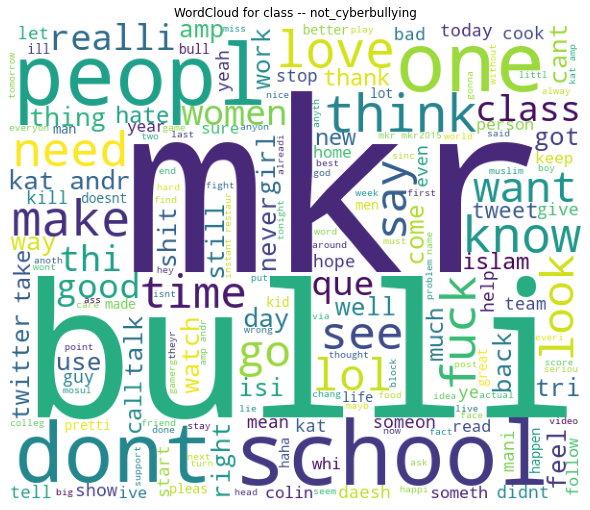

In [34]:
stopwords = set(STOPWORDS)

df_not_text = ''
for x in df[df['cyberbullying_type'] == 'not_cyberbullying']['text_preprocessed']:
    for y in x.split(" "):
        df_not_text = df_not_text+" "+ y

wordcloud = WordCloud(width = 600, height = 500,
                background_color ='white',
                stopwords = stopwords,
                min_font_size = 10).generate(df_not_text)
 
# plot the WordCloud for class -- not_cyberbullying                      
plt.figure(figsize = (8, 8), facecolor = None)
plt.title("WordCloud for class -- not_cyberbullying")
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
 
plt.show()

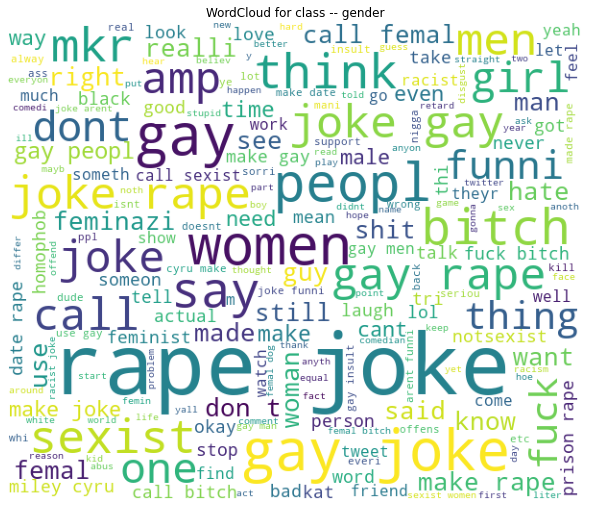

In [35]:
df_gender_text = ''
count = 0
for x in df[df['cyberbullying_type'] == 'gender']['text_preprocessed']:
    for y in x.split(" "):
        df_gender_text = df_gender_text+" "+ y
        count += 1
        

wordcloud = WordCloud(width = 600, height = 500,max_words=count,
                background_color ='white',
                stopwords = stopwords,
                min_font_size = 10).generate(df_gender_text)
 
# plot the WordCloud for class -- gender                     
plt.figure(figsize = (8, 8), facecolor = None)
plt.title("WordCloud for class -- gender")
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
 
plt.show()

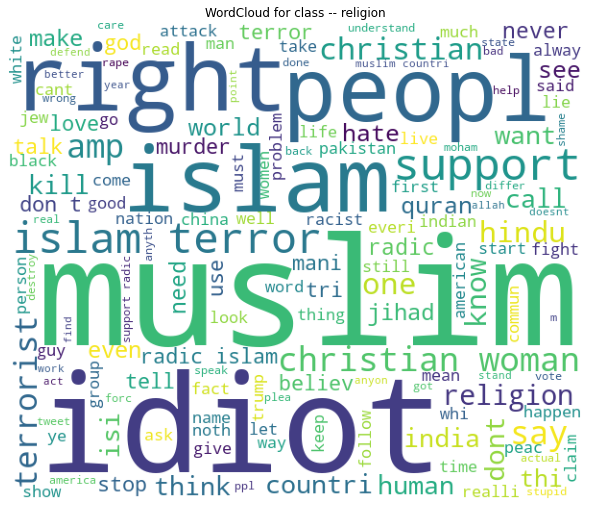

In [29]:
df_religion_text = ''
count = 0
for x in df[df['cyberbullying_type'] == 'religion']['text_preprocessed']:
    for y in x.split(" "):
        df_religion_text = df_religion_text+" "+ y
        count += 1
        
wordcloud = WordCloud(width = 600, height = 500,max_words=count,
                background_color ='white',
                stopwords = stopwords,
                min_font_size = 10).generate(df_religion_text)
 
# plot the WordCloud for class -- religion                    
plt.figure(figsize = (8, 8), facecolor = None)
plt.title("WordCloud for class -- religion")
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
 
plt.show()

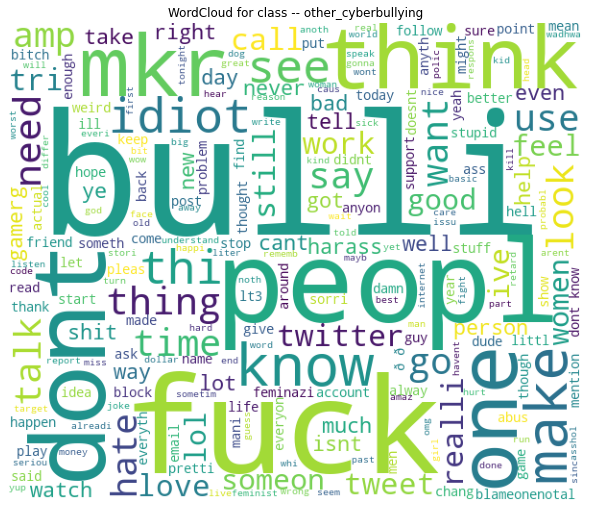

In [36]:
df_other_cyberbullying_text = ''
count = 0
for x in df[df['cyberbullying_type'] == 'other_cyberbullying']['text_preprocessed']:
    for y in x.split(" "):
        df_other_cyberbullying_text = df_other_cyberbullying_text+" "+ y
        count += 1
        
wordcloud = WordCloud(width = 600, height = 500,max_words=count,
                background_color ='white',
                stopwords = stopwords,
                min_font_size = 10).generate(df_other_cyberbullying_text)
 
# plot the WordCloud for class -- other_cyberbullying                    
plt.figure(figsize = (8, 8), facecolor = None)
plt.title("WordCloud for class -- other_cyberbullying")
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
 
plt.show()

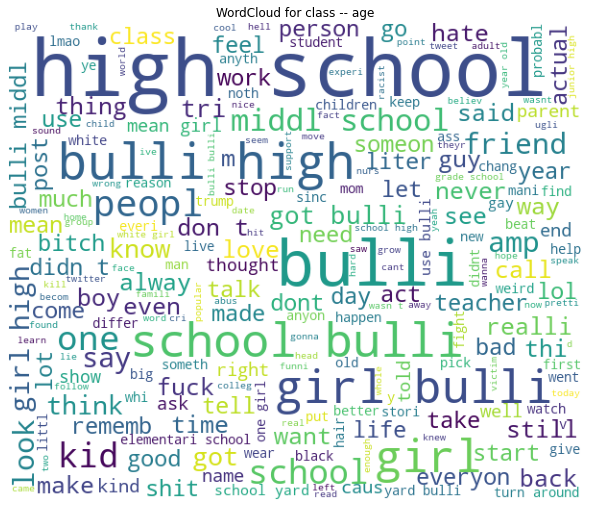

In [40]:
df_age_text = ''
count = 0
for x in df[df['cyberbullying_type'] == 'age']['text_preprocessed']:
    for y in x.split(" "):
        df_age_text = df_age_text+" "+ y
        count += 1
        
wordcloud = WordCloud(width = 600, height = 500,max_words=count,
                background_color ='white',
                stopwords = stopwords,
                min_font_size = 10).generate(df_age_text)
 
# plot the WordCloud for class -- age                    
plt.figure(figsize = (8, 8), facecolor = None)
plt.title("WordCloud for class -- age")
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
 
plt.show()

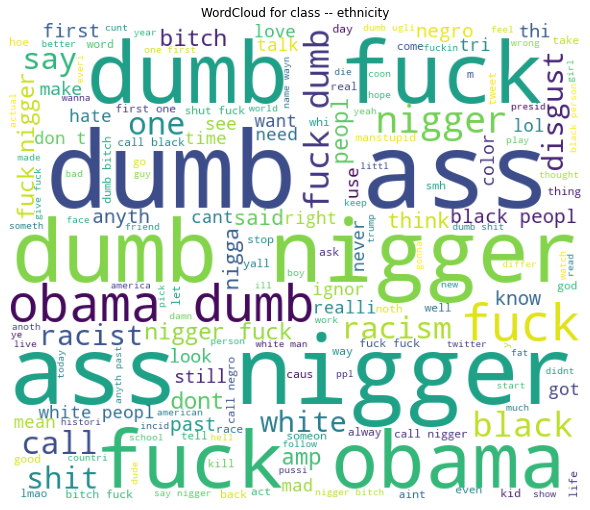

In [38]:
df_ethnicity_text = ''
count = 0
for x in df[df['cyberbullying_type'] == 'ethnicity']['text_preprocessed']:
    for y in x.split(" "):
        df_ethnicity_text = df_ethnicity_text+" "+ y
        count += 1
        
wordcloud = WordCloud(width = 600, height = 500,max_words=count,
                background_color ='white',
                stopwords = stopwords,
                min_font_size = 10).generate(df_ethnicity_text)
 
# plot the WordCloud for class -- ethnicity                    
plt.figure(figsize = (8, 8), facecolor = None)
plt.title("WordCloud for class -- ethnicity")
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
 
plt.show()

### <center> Observing all the results its sure that some words occur more frequently with different class labels and definitly helps in classifing the output class based on occurance of each word in that particular class field</center>